Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3, 'criterion': 'gini'}
Best Model Accuracy: 0.5


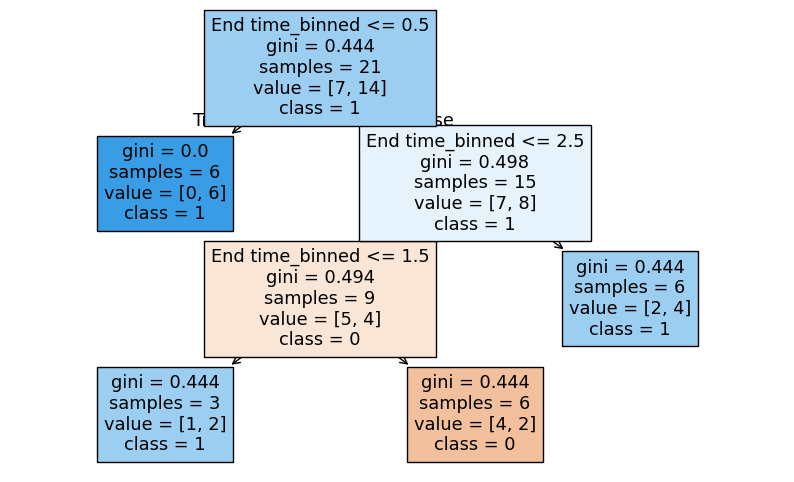

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


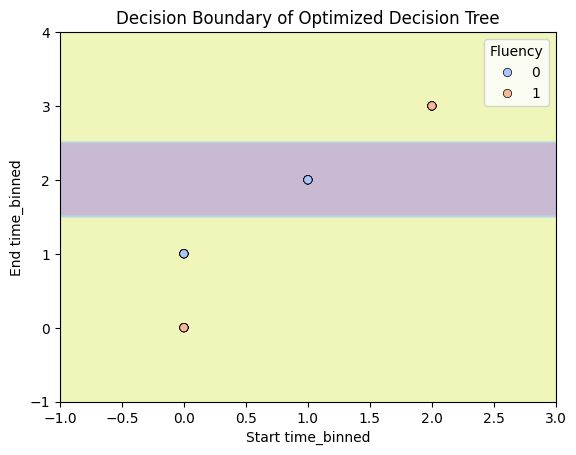

In [6]:
#2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from math import log2
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

# Function to calculate entropy
def entropy(y):
    counts = Counter(y)
    total = len(y)
    return -sum((count / total) * log2(count / total) for count in counts.values())

# Function to calculate Information Gain
def information_gain(data, feature, target):
    total_entropy = entropy(data[target])
    values, counts = np.unique(data[feature], return_counts=True)
    weighted_entropy = sum((counts[i] / sum(counts)) * entropy(data[data[feature] == values[i]][target]) for i in range(len(values)))
    return total_entropy - weighted_entropy

# Function for binning continuous features
def bin_continuous_feature(data, column, num_bins=3, method='equal_width'):
    """Bins a continuous feature using equal-width or equal-frequency binning."""
    if method not in ['equal_width', 'equal_frequency']:
        raise ValueError("Invalid binning method. Choose 'equal_width' or 'equal_frequency'.")

    if method == 'equal_width':
        data[column + '_binned'] = pd.cut(data[column], bins=num_bins, labels=False)
    else:  # equal_frequency
        data[column + '_binned'] = pd.qcut(data[column], q=num_bins, labels=False, duplicates='drop')

    return data

# Load and preprocess data
data = pd.read_excel("output_s234.xlsx", sheet_name="Sheet1")

# Binning continuous features
data = bin_continuous_feature(data, 'Start time')
data = bin_continuous_feature(data, 'End time', num_bins=4, method='equal_frequency')

# Encode categorical features
label_encoders = {}
for col in ['Start time_binned', 'End time_binned', 'Member', 'Fluency']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Splitting dataset
X = data[['Start time_binned', 'End time_binned']]
y = data['Fluency']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Decision Tree and hyperparameter grid
dt = DecisionTreeClassifier(random_state=42)
param_dist = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Apply RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(dt, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Hyperparameters:", random_search.best_params_)

# Train the best model
best_dt = random_search.best_estimator_
best_dt.fit(X_train, y_train)

# Evaluate performance
accuracy = best_dt.score(X_test, y_test)
print("Best Model Accuracy:", accuracy)

# Visualizing Decision Tree
plt.figure(figsize=(10, 6))
plot_tree(best_dt, feature_names=X.columns, class_names=[str(cls) for cls in np.unique(y)], filled=True)
plt.show()

# Plot Decision Boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='coolwarm', edgecolor='black', linewidth=0.5)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.title("Decision Boundary of Optimized Decision Tree")
    plt.show()

# Plot decision boundary for the optimized model
plot_decision_boundary(best_dt, X, y)


In [ ]:
#3